In [255]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from numpy import shape
import random
from PIL import Image

In [256]:
# Game of Life 
# die if less than two live neighbours
# survive if two or three live neighbours
# die if more than three live neighbours
# revive if three live neighbours

**Data Generation and Gathering**

In [257]:
# evolve board according certain laws, here the law is classical game of life
def evolve(board):
    output = np.zeros(board.shape)
    for x in range (board.shape[0]):
        for y in range (board.shape[1]):
            neighbours=count_neighbours(board,x,y)
            if ((board[x,y] == 0 and neighbours == 3) or (board[x,y] == 1 and 2 <= neighbours <= 3)):
                output[x,y] = 1
    return output

# count number of alive neighbours for each cell 
def count_neighbours(board,x,y):
    neighbours = -board[x,y]
    for i in (-1, 0, 1):
        for j in (-1, 0, 1):
            xi = (x + i) % board.shape[0] # impose periodic boundary conditions
            yj = (y + j) % board.shape[1]
            neighbours += board[xi,yj]
            if neighbours > 3:
                return neighbours
    return neighbours

**Constructing Model**

In [258]:
# Define a custom cyclic padding layer
class CyclicPadding(nn.Module):
    def forward(self, board):
        # Pad the input tensor cyclically in both dimensions (height and width)
        cyclic_board_row = torch.cat([board, board[:, :, :1, :]], dim=2)
        cyclic_board_row = torch.cat([board[:, :, -1:, :], cyclic_board_row], dim=2)
        cyclic_board = torch.cat([cyclic_board_row, cyclic_board_row[:, :, :, :1]], dim=3)
        cyclic_board = torch.cat([cyclic_board_row[:, :, :, -1:], cyclic_board], dim=3)
        return cyclic_board

# Define a custom neural network model
class CustomModel(nn.Module):
    def __init__(self, m):
        super(CustomModel, self).__init__()
        
        # Initialize the layers of the model
        self.cyclic_padding = CyclicPadding()
        self.conv1 = nn.Conv2d(1, 2 * m, kernel_size=(3, 3))  # First convolutional layer
        self.conv2 = nn.Conv2d(2 * m, 1 * m, kernel_size=(1, 1))  # Second convolutional layer
        self.conv3 = nn.Conv2d(1 * m, 1, kernel_size=(1, 1))  # Third convolutional layer

    def forward(self, x):
        # Apply cyclic padding to the input tensor
        x = self.cyclic_padding(x)
        
        # Apply convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # Apply the final convolutional layer with sigmoid activation
        x = torch.sigmoid(self.conv3(x))
        return x

# Create an instance of the custom model with a specified 'm' value
m = 3  # You can adjust the value of 'm' as needed
model = CustomModel(m)

# Print model summary
print(model)


CustomModel(
  (cyclic_padding): CyclicPadding()
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
)


**Loading Data**

In [259]:
from torch.utils.data import DataLoader, TensorDataset

# Define the parameters
batch_size = 20
sample_size = 100 # sample_size is number of instances to train on each epoch, should be multiple of batch_size
board_size = 10
delay = 5

# Create the data generator
# define the generator that generate training data for machine to learn
# sample_size: the number of sample pair generated each time the function is called
# board_size: the size of the board
# delay: wait for this much of time after initialization to take data 
def data_generator(sample_size, board_size, delay):
    while True:
        x_train = []
        y_train = []
        for _ in range(sample_size):
            board = np.zeros((board_size, board_size, 1))
            # d = random.uniform(0,1)
            d = 0.6
            for x in range(board_size):
                for y in range(board_size):
                    if random.uniform(0,1) < d:
                        board[x, y, 0] = 1
            for _ in range(delay):
                board = evolve(board)
            x_train.append(board)
            y_train.append(evolve(board))
        # To adapt your data for PyTorch, reshape or transpose your data from (5, 10, 10, 1) to (5, 1, 10, 10).
        # i.e.  from (batch, height, width, channels) to (batch, channels, height, width)
        x_train = np.array(x_train).transpose(0, 3, 1, 2)  # Adjust the dimensions
        y_train = np.array(y_train).transpose(0, 3, 1, 2)  # Adjust the dimensions

        # Convert to PyTorch tensors
        x_train = torch.Tensor(x_train)
        y_train = torch.Tensor(y_train)
        yield x_train, y_train


# Initialize the data generator
generator = data_generator(sample_size, board_size, delay)

# Create the train_dataset with the first batch of samples
x_batch, y_batch = next(generator)
train_dataset = TensorDataset(x_batch, y_batch)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

**Train Model**

In [260]:
# For activation and filter visualization

# Define hooks
activations = {}
filters = {}

def capture_activations(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

# Register hooks
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        layer.register_forward_hook(capture_activations(name))
        filters[name] = layer.weight 

In [261]:
import torch.optim as optim
import time

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

num_epochs = 500
num_batches = len(train_loader)

loss_his = []
epoch_activations = {}
epoch_filters = {}
epochs = np.arange(num_epochs)
for epoch in epochs:
    running_loss = 0.0
    start_time = time.time()

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Updating filters after model update
        for name, layer in model.named_modules():
            if isinstance(layer, torch.nn.Conv2d):
                filters[name] = layer.weight

        # print progress bar
        progress = (i + 1) / num_batches
        arrow = '-' * int(round(progress * 20)-1) + '>'
        spaces = ' ' * (20 - len(arrow))

        print(f'\rEpoch {epoch + 1}/{num_epochs} [{arrow + spaces}] {i + 1}/{num_batches} - loss: {running_loss / (i + 1):.4f}', end='')
    
    loss_his.append(running_loss / (i + 1))
    epoch_activations[epoch] = dict(activations)  # Make a deep copy so that data from current epoch is saved
    epoch_filters[epoch] = {name: weights.detach().clone() for name, weights in filters.items()}  # Store a detached copy of the tensors

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'\rEpoch {epoch + 1}/{num_epochs} [{arrow + spaces}] {i + 1}/{num_batches} - {epoch_time:.2f}s - loss: {running_loss / num_batches:.4f}')
    running_loss = 0.0
    
# store model statistics
loss_curve = (epochs, loss_his)
activations = []
filters = []

# visualize filters and activations at specific epochs
epochs_visual = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420] # to see long term evolution
#epochs_visual = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] # to investigate why the loss drop rapidly in first few epochs
for epoch in epochs_visual:
    activations.append(epoch_activations[epoch])
    filters.append(epoch_filters[epoch])

Epoch 1/500 [------------------->] 5/5 - 0.09s - loss: 0.6025
Epoch 2/500 [------------------->] 5/5 - 0.03s - loss: 0.5478
Epoch 3/500 [------------------->] 5/5 - 0.01s - loss: 0.5049
Epoch 4/500 [------------------->] 5/5 - 0.02s - loss: 0.4708
Epoch 5/500 [------------------->] 5/5 - 0.09s - loss: 0.4436
Epoch 6/500 [------------------->] 5/5 - 0.03s - loss: 0.4219
Epoch 7/500 [------------------->] 5/5 - 0.02s - loss: 0.4046
Epoch 8/500 [------------------->] 5/5 - 0.02s - loss: 0.3907
Epoch 9/500 [------------------->] 5/5 - 0.02s - loss: 0.3795
Epoch 10/500 [------------------->] 5/5 - 0.02s - loss: 0.3705
Epoch 11/500 [------------------->] 5/5 - 0.02s - loss: 0.3630
Epoch 12/500 [------------------->] 5/5 - 0.02s - loss: 0.3567
Epoch 13/500 [------------------->] 5/5 - 0.02s - loss: 0.3514
Epoch 14/500 [------------------->] 5/5 - 0.02s - loss: 0.3468
Epoch 15/500 [------------------->] 5/5 - 0.02s - loss: 0.3427
Epoch 16/500 [------------------->] 5/5 - 0.06s - loss: 0.3389
E

Epoch 131/500 [------------------->] 5/5 - 0.08s - loss: 0.1418
Epoch 132/500 [------------------->] 5/5 - 0.03s - loss: 0.1415
Epoch 133/500 [------------------->] 5/5 - 0.03s - loss: 0.1411
Epoch 134/500 [------------------->] 5/5 - 0.02s - loss: 0.1408
Epoch 135/500 [------------------->] 5/5 - 0.02s - loss: 0.1405
Epoch 136/500 [------------------->] 5/5 - 0.02s - loss: 0.1401
Epoch 137/500 [------------------->] 5/5 - 0.01s - loss: 0.1398
Epoch 138/500 [------------------->] 5/5 - 0.02s - loss: 0.1395
Epoch 139/500 [------------------->] 5/5 - 0.05s - loss: 0.1392
Epoch 140/500 [------------------->] 5/5 - 0.02s - loss: 0.1388
Epoch 141/500 [------------------->] 5/5 - 0.01s - loss: 0.1385
Epoch 142/500 [------------------->] 5/5 - 0.03s - loss: 0.1382
Epoch 143/500 [------------------->] 5/5 - 0.01s - loss: 0.1379
Epoch 144/500 [------------------->] 5/5 - 0.02s - loss: 0.1375
Epoch 145/500 [------------------->] 5/5 - 0.02s - loss: 0.1372
Epoch 146/500 [------------------->] 5/5

Epoch 263/500 [------------------->] 5/5 - 0.06s - loss: 0.0929
Epoch 264/500 [------------------->] 5/5 - 0.02s - loss: 0.0925
Epoch 265/500 [------------------->] 5/5 - 0.02s - loss: 0.0922
Epoch 266/500 [------------------->] 5/5 - 0.02s - loss: 0.0918
Epoch 267/500 [------------------->] 5/5 - 0.03s - loss: 0.0915
Epoch 268/500 [------------------->] 5/5 - 0.02s - loss: 0.0912
Epoch 269/500 [------------------->] 5/5 - 0.00s - loss: 0.0907
Epoch 270/500 [------------------->] 5/5 - 0.10s - loss: 0.0904
Epoch 271/500 [------------------->] 5/5 - 0.05s - loss: 0.0900
Epoch 272/500 [------------------->] 5/5 - 0.04s - loss: 0.0896
Epoch 273/500 [------------------->] 5/5 - 0.03s - loss: 0.0893
Epoch 274/500 [------------------->] 5/5 - 0.02s - loss: 0.0889
Epoch 275/500 [------------------->] 5/5 - 0.01s - loss: 0.0885
Epoch 276/500 [------------------->] 5/5 - 0.02s - loss: 0.0882
Epoch 277/500 [------------------->] 5/5 - 0.05s - loss: 0.0878
Epoch 278/500 [------------------->] 5/5

Epoch 396/500 [------------------->] 5/5 - 0.02s - loss: 0.0484
Epoch 397/500 [------------------->] 5/5 - 0.02s - loss: 0.0481
Epoch 398/500 [------------------->] 5/5 - 0.02s - loss: 0.0478
Epoch 399/500 [------------------->] 5/5 - 0.05s - loss: 0.0475
Epoch 400/500 [------------------->] 5/5 - 0.03s - loss: 0.0472
Epoch 401/500 [------------------->] 5/5 - 0.03s - loss: 0.0469
Epoch 402/500 [------------------->] 5/5 - 0.02s - loss: 0.0467
Epoch 403/500 [------------------->] 5/5 - 0.04s - loss: 0.0464
Epoch 404/500 [------------------->] 5/5 - 0.04s - loss: 0.0461
Epoch 405/500 [------------------->] 5/5 - 0.02s - loss: 0.0459
Epoch 406/500 [------------------->] 5/5 - 0.02s - loss: 0.0455
Epoch 407/500 [------------------->] 5/5 - 0.03s - loss: 0.0453
Epoch 408/500 [------------------->] 5/5 - 0.05s - loss: 0.0450
Epoch 409/500 [------------------->] 5/5 - 0.03s - loss: 0.0448
Epoch 410/500 [------------------->] 5/5 - 0.03s - loss: 0.0445
Epoch 411/500 [------------------->] 5/5

In [262]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def extract_all(epochs, activations, filters, m):
    activation_imgs = []
    filter_imgs = []
    for idx, epoch in enumerate(epochs):
        # Extracting only conv1 activations and filters
        act = activations[idx]['conv1'].detach().cpu().numpy() 
        fil = filters[idx]['conv1'].detach().cpu().numpy()
        for j in range(2*m):
            activation_imgs.append(act[0][j])
        for j in range(2*m):
            filter_imgs.append(fil[j][0])
            
    return activation_imgs, filter_imgs

activation_imgs, filter_imgs = extract_all(epochs_visual, activations, filters, m)
activation_imgs = np.asarray(activation_imgs)
filter_imgs = np.asarray(filter_imgs)

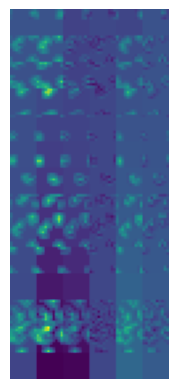

In [263]:
def plot_activations(imgs, epochs, m, **options):
    images_per_row = 2*m
    n_rows = len(epochs)
    size = len(imgs[0][0])

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(imgs)
    padded_imgs = np.concatenate([imgs, np.zeros((n_empty, size, size))], axis=0)

    image_grid = padded_imgs.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # plot the matrix using imshow
    plt.imshow(big_image, cmap='viridis', **options)
    plt.axis("off")

plot_activations(activation_imgs, epochs_visual, m)

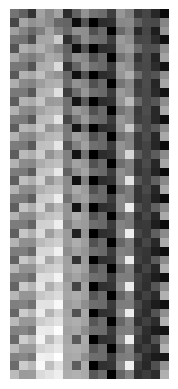

In [264]:
def plot_filters(imgs, epochs, m, **options):
    images_per_row = 2*m
    n_rows = len(epochs)
    size = len(imgs[0][0])

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(imgs)
    padded_imgs = np.concatenate([imgs, np.zeros((n_empty, size, size))], axis=0)

    image_grid = padded_imgs.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # plot the matrix using imshow
    plt.imshow(big_image, cmap='gray', **options)
    plt.axis("off")

plot_filters(filter_imgs, epochs_visual, m)

**Testing**

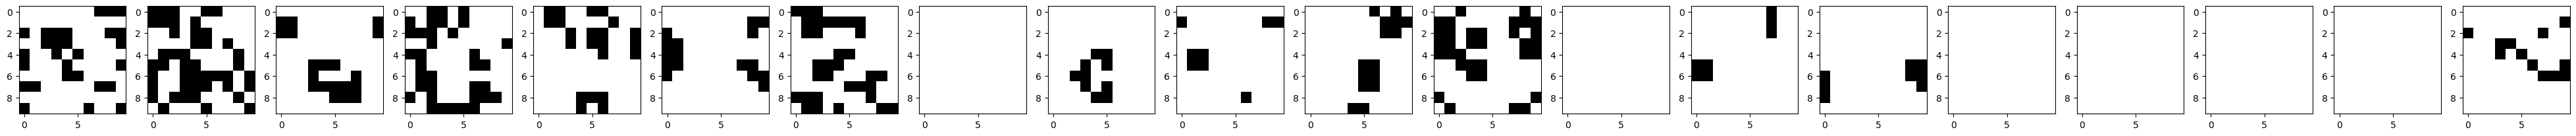

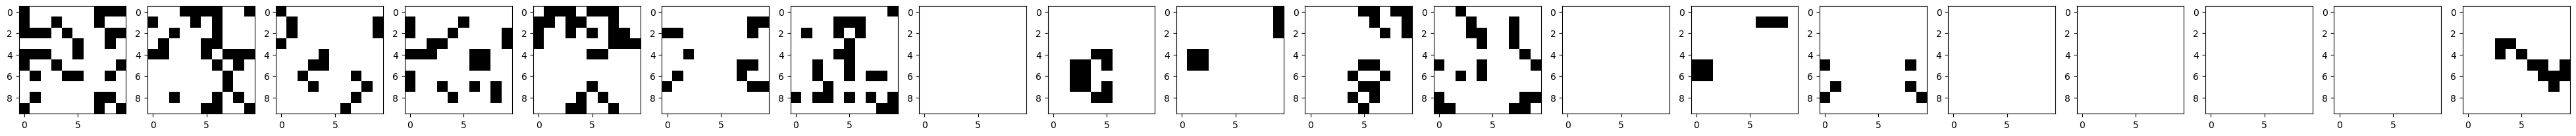

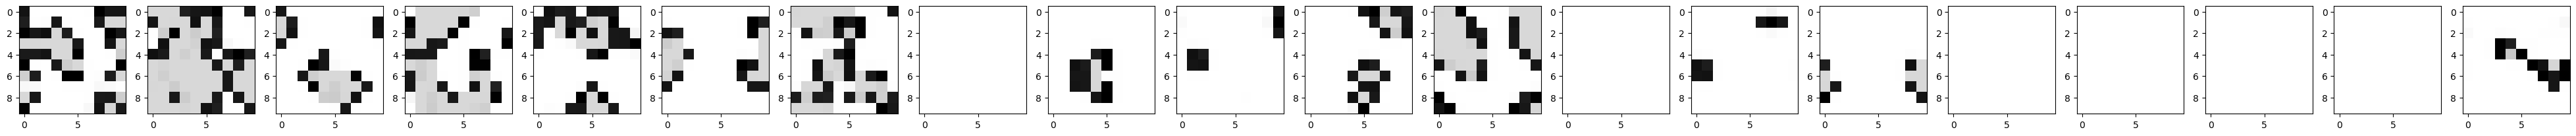

In [265]:
def remove_hooks(model):
    for module in model.modules():
        module._forward_hooks.clear()

remove_hooks(model)

def board_generator(sample_size, board_size, delay):
    x_test = []
    y_test = []
    for i in range(sample_size):
        board = np.zeros((board_size, board_size, 1))
        d = random.uniform(0.1, 0.7)
        for x in range(board_size):
            for y in range(board_size):
                if random.uniform(0, 1) < d:
                    board[x, y, 0] = 1
        for i in range(delay):
            board = evolve(board)  # This already works with numpy arrays.
        x_test.append(board)
        y_test.append(evolve(board))
    
    x_test = np.array(x_test).transpose(0, 3, 1, 2)  # Adjusting for PyTorch
    y_test = np.array(y_test).transpose(0, 3, 1, 2)  # Adjusting for PyTorch
    
    # Convert to PyTorch tensors
    x_test_tensor = torch.Tensor(x_test)
    
    # Get predictions
    with torch.no_grad():
        model.eval()  
        y_pred_tensor = model(x_test_tensor)
        y_pred = y_pred_tensor.numpy().transpose(0, 1, 2, 3)  # Convert back to the original shape
    
    return x_test, y_test, y_pred

data = board_generator(20, 10, 5)

for i in range (len(data)):
    fig,ax=plt.subplots(1,shape(data[1])[0],figsize=(50, 50))
    for j in range (shape(data[1])[0]):
        board_reshape = data[i][j].transpose(2, 1, 0)
        ax[j].imshow(board_reshape,cmap=plt.cm.Greys)
        
# the first row is the test boards at time t 
# the second row is the corresponding test boards at time t+1
# the third row is the predicted boards at t+1 given by machine based on the test boards at time t

**Saving Model (if needed)**

In [266]:
import os
import pickle
import torch

if not os.path.exists('models'):
    os.makedirs('models')

def save_model_and_data(model, num_epochs, m, loss_curve, model_type="CustomModel"):
    # Create a formatted name
    file_name = "{}_{}epoch_m={}".format(model_type, num_epochs, m)
    model_dir = os.path.join('models', file_name)
    
    # Create directory for the model if it doesn't exist
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Set paths for model and data
    model_path = os.path.join(model_dir, file_name + ".pth")
    data_path = os.path.join(model_dir, file_name + "_data.pkl")
    
    # Save the model
    torch.save(model.state_dict(), model_path)
    
    # Save the loss curve and any other data you want
    data = {
        "loss_curve": {
            "epochs": loss_curve[0],
            "loss_his": loss_curve[1]
        }
        # ... any other data you want to save
    }
    
    with open(data_path, 'wb') as f:
        pickle.dump(data, f)

save_model_and_data(model, num_epochs, m, loss_curve)

**Load Model**

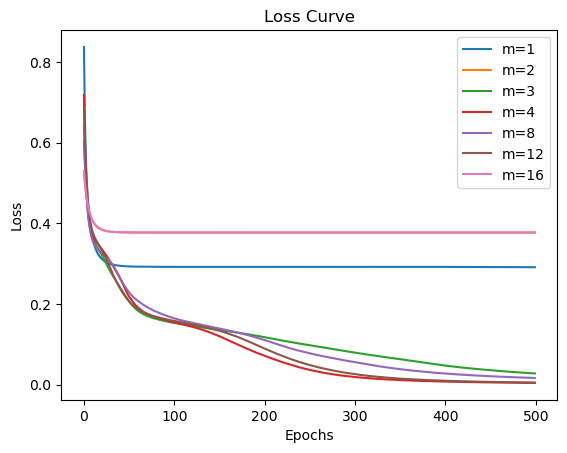

In [267]:
def load_model_and_data(model_type="CustomModel", epoch=None, m=None):
    # Create a formatted name
    file_name = "{}_{}epoch_m={}".format(model_type, epoch, m)
    model_dir = os.path.join('models', file_name)
    
    # Paths for model and data
    model_path = os.path.join(model_dir, file_name + ".pth")
    data_path = os.path.join(model_dir, file_name + "_data.pkl")
    
    # Load model
    model = CustomModel(m)  # Pass the required 'm' parameter
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    
    # Load data
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    
    return model, data


# Example usage:
ms = [1, 2, 3, 4, 8, 12, 16]
for m in ms:
    model_, data = load_model_and_data("CustomModel", 500, m)
    epochs = data["loss_curve"]["epochs"]
    loss_his = data["loss_curve"]["loss_his"]
    plt.plot(epochs, loss_his, label=f'm={m}')  # Updated label format

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()  # Add legend to distinguish different m values
plt.show()


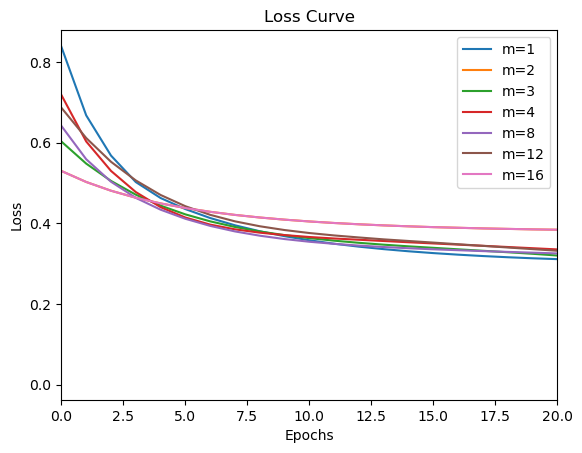

In [268]:
# Example usage:
ms = [1, 2, 3, 4, 8, 12, 16]
for m in ms:
    model, data = load_model_and_data("CustomModel", 500, m)
    epochs = data["loss_curve"]["epochs"]
    loss_his = data["loss_curve"]["loss_his"]
    plt.plot(epochs, loss_his, label=f'm={m}')  # Updated label format

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()  # Add legend to distinguish different m values
plt.xlim(0,20)
plt.show()